## <center> COVID-19-Simulation</center>

### Part 0: A SEIR cellular automata model:


#### Data Source:
Coronavirus COVID-19 Global Cases by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)
- [Blog](https://systems.jhu.edu/research/public-health/ncov/)
- [Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6)

#### Data used:
[CSSEGISandData](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)
    1. time_series_covid19_confirmed_US.csv
    2. time_series_covid19_confirmed_global.csv
    3. time_series_covid19_deaths_US.csv
    4. time_series_covid19_deaths_global.csv
    5. time_series_covid19_recovered_global.csv
    
    

#### Data Pre-processing, basic statistics and insights:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def preprocess_US(data_url):
    df = pd.read_csv(data_url)
    last_update_date = df.keys()[-1]
    df.drop(['UID','iso2','iso3','code3','FIPS','Admin2','Lat','Long_'], axis = 1, inplace = True)
    df_cleaned= df.groupby(['Province_State'], as_index = False).sum()
    df_sorted = df_cleaned.sort_values(by=last_update_date,ascending=False).reset_index(drop=True)
    update_total = sum(df_sorted[last_update_date])
    return df_sorted, last_update_date, update_total


In [2]:
### Retrieve data from CSSEGISandData Github Raw content in csv
url_confirmed_US = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
url_deaths_US = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'


df_confirmed_US,last_confirmed_US,total_confirmed_US = preprocess_US(url_confirmed_US)
df_deaths_US,last_deaths_US,total_deaths_US = preprocess_US(url_deaths_US)
first_date_US = df_confirmed_US.keys()[1]
print("Data Basic Statistics: \n")
print('From {} till {} the US confirmed cases total is : {} \n'.format(first_date_US,last_confirmed_US,total_confirmed_US))
print('From {} till {} the US deaths cases total is : {} \n'.format(first_date_US,last_deaths_US,total_deaths_US))
mortality_rate = float(total_deaths_US)/float(total_confirmed_US)*100
print('Mortality rate in US is being updated as {:.3f}% \n'.format(mortality_rate))
US_population_list = df_deaths_US['Population']
US_population = US_population_list.sum()
df_deaths_US.drop(['Population'], axis = 1, inplace = True)
print('COVID-19 is among US population of {:.5f}% and fatal rate is {:.5f}% \n'.format(float(total_confirmed_US)/float(US_population)*100, float(total_deaths_US)/float(US_population)*100))

Data Basic Statistics: 

From 1/22/20 till 4/8/20 the US confirmed cases total is : 429047 

From 1/22/20 till 4/8/20 the US deaths cases total is : 14694 

Mortality rate in US is being updated as 3.425% 

COVID-19 is among US population of 0.12761% and fatal rate is 0.00437% 



In [3]:
def get_top_rank(sorted_df,compare_df,rank):
    # Create an empty list
    container = {}
    rows_list = []
    rows_compare_list=[]
    state_sorted_order = []
    # Iterate over each row 
    for index, row in sorted_df.iterrows():
        if index <rank:
            row_list = row.to_list()
            container[row_list[0]] = [row_list[1:]]
            state_sorted_order.append(row_list[0])
    for index_compare, row_compare in compare_df.iterrows():
        row_compare_list = row_compare.to_list()
        if row_compare_list[0] in container:
            container[row_compare_list[0]].append(row_compare_list[1:])
    return container, state_sorted_order
        
    

container, state_list = get_top_rank(df_confirmed_US,df_deaths_US,5)


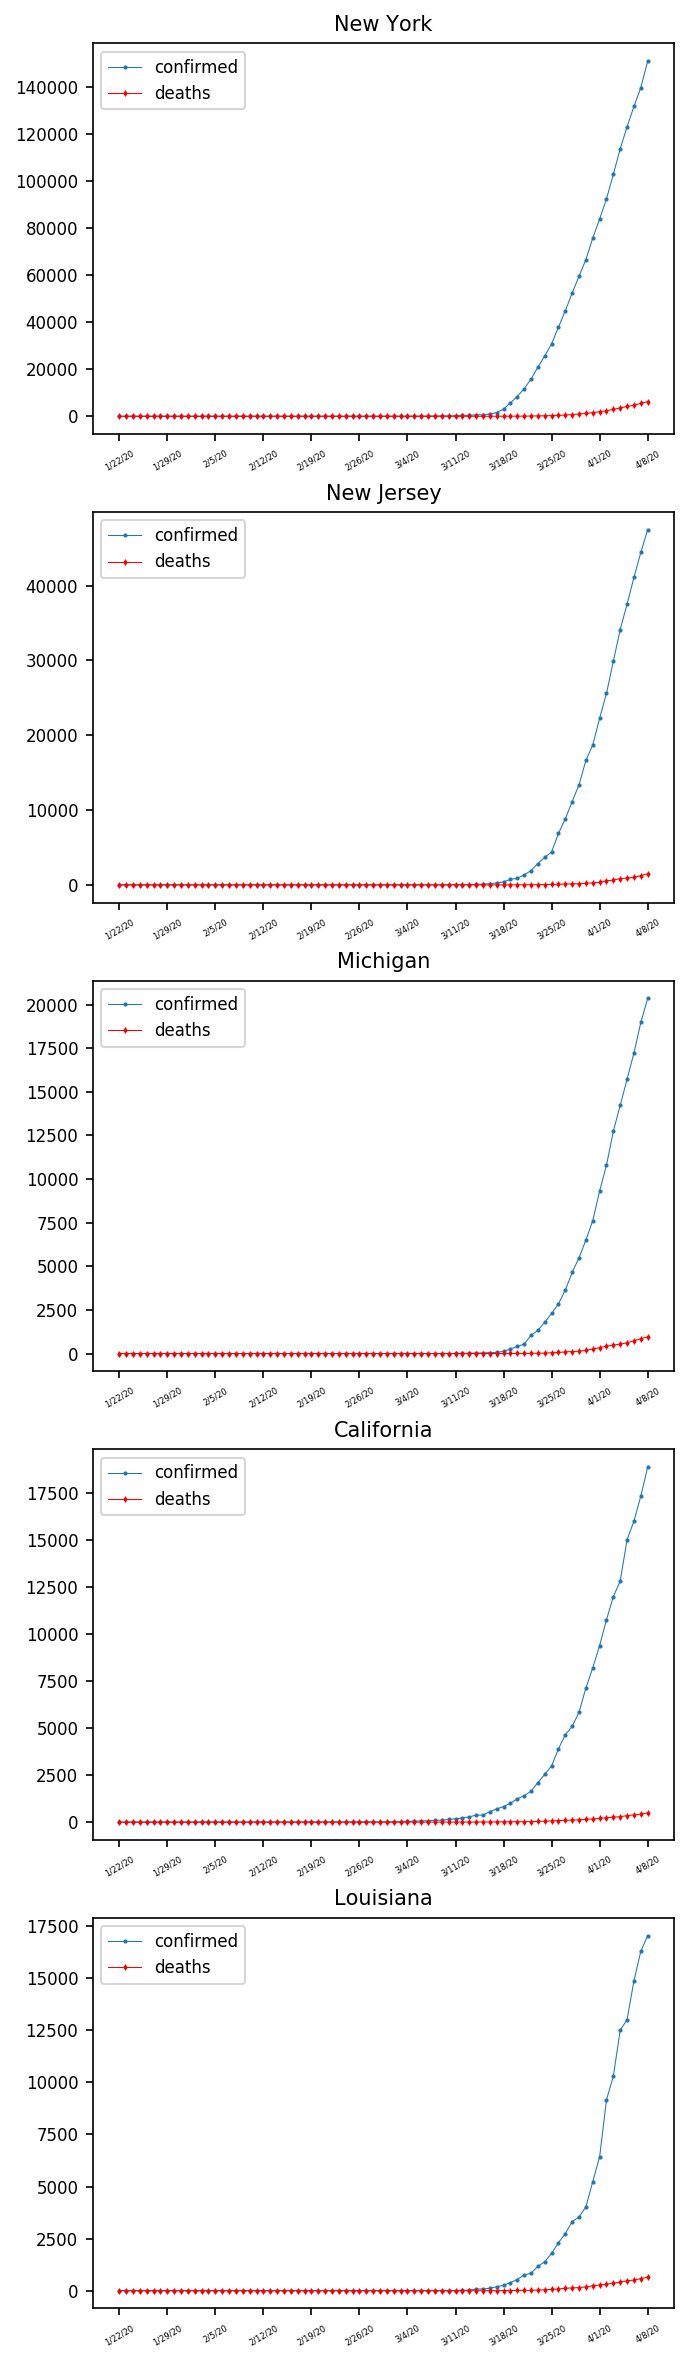

In [4]:
fig, ax = plt.subplots(ncols = 1, nrows = len(state_list), figsize = (5,20), dpi = 150)
date = df_confirmed_US.keys()[1:]

for i in range(len(state_list)):
    ax[i].plot(date,container[state_list[i]][0],'o-',label="confirmed", linewidth=0.5,markersize=1)
    ax[i].plot(date,container[state_list[i]][1],'rd-',label= "deaths", linewidth=0.5,markersize=1)
    ax[i].set_title(state_list[i],fontsize = 10)
    ax[i].tick_params(axis='x',labelsize=4)
    ax[i].tick_params(axis='y',labelsize=8)
    ax[i].legend(fontsize = 8)
    ax[i].set_xticks(date[::7])
    ax[i].set_xticklabels(date[::7], rotation=30)





#### Conceptual Model:
1. Disease Model: SEIR
2. Cellular Automata Framework:
3. Geographical Model:

#### 1. Disease Model: SEIR

An analysis of COVID-19 publicly reported confirmed cases in the early stage of the pandemic, from [Lauer SA et al.](https://annals.org/AIM/FULLARTICLE/2762808/INCUBATION-PERIOD-CORONAVIRUS-DISEASE-2019-COVID-19-FROM-PUBLICLY-REPORTED)[1], estimated that that COVID-19 has a mean incubation period approximately of 5 days, and 97.5 percent of people will develop symptons within 11.5 days of infection.<br>
The incubation period is the time between exposure to the disease and starting to show symptoms. It is usually considered before the contagious period, when infected individual can transmit the virus to others. However, there are cases reported by [Rothe, C. et al.](https://doi.org/10.1056/NEJMc2001468) [2] showing that asymptomatic persons are potential sources of 2019-nCoV infection, which means the COVID-19 could be contagious even during the late stage of incubation period. Research by [Zou, Lirong, et al.](https://www.nejm.org/doi/full/10.1056/NEJMc2001737)[3] on viral load of asymptomatic infected patients also support this, and warrants a reassessment of transmission dynamics of the current outbreak. <br>
In this simulation, a SEIR model (Susceptible, Exposed, Infectious, Recovered) was selected to describe the spread of COVID-19. Compared to the SIR model, an "Exposed" population category was added to describe the infected population during the incubation period. However, as the study suggested, it is unknown yet how large in scale can the infected people during the incubation period be infectious. To address this concern, an extra probability layer with a tunable variable was added to decribe how soon people in "E" become "I". And we assume the recovered individual will have total immune to the COVID-19.

THE **SEIR**  system can be described as below:
1. $N=S+E+I+R$

> where N is the total number of population, S is the susceptible, E is the exposed, I is the infected, R is the recovered or deaths. Here the R inclues death population, because death also stops the spread of virus, which has similar impact to the model like recovered with total immune. 
    
2. ODE equations:
<center>
    $\frac{dS}{dT} = - \beta S I$ <br>
    $\frac{dE}{dT} = \beta S I - \alpha E$ <br>
    $\frac{dI}{dT} = \alpha E - \gamma I$ <br>
    $\frac{dR}{dT} = \gamma I$ <br>
</center> 

> where $\alpha$ is the inverse of the incubation period, $\alpha = \frac{1}{T_{incubation}}$ ;
$\beta$ is the average exposure rate in the population over time;
$\gamma$ is the average immune or fatal rate in the population over time, $\gamma = \frac{1}{T_{infectious}}$, is the inverse of the average infectious period. This means how fast infected individual become death or recovered. Either case stops the spread and ends the infectious period. 

3. $R_O$ value:

> The $R_O$ value is the reproduction number of an epidemic disease. It describes what would happen if an infectious person were to enter a fully susceptible community, and therefore is an estimate based on an idealized scenario. Intuitively assumption can be made that among the three SEIR ODE system parameters $\alpha$,$\beta$,$\gamma$, clearly if $\beta$ is large, meaning the exposure rate is large, could amplify the reproduction among the population. While if $\gamma$ is small, meaning the recover rate is slow, infectious period is longer, could also amplify the reproduction. <br>

Thus we could come up with a simple estimation equation of:
$$R_O = \frac{\beta}{\gamma}$$
This equation indicates the relation ship between the $\beta$ and $\gamma$, when an $R_O$ numebr is given. The popularly acknowledged $R_O$ numebr for COVID-19 is about 2.28.[Zhang, Sheng, et al.](https://www.sciencedirect.com/science/article/pii/S1201971220300916?via%3Dihub)[4].












##### Reference:
[1] Lauer SA, Grantz KH, Bi Q, et al. The Incubation Period of Coronavirus Disease 2019 (COVID-19) From Publicly Reported Confirmed Cases: Estimation and Application. Ann Intern Med. 2020; [Epub ahead of print 10 March 2020]. doi: https://doi.org/10.7326/M20-0504

[2] Rothe, C. et al. Transmission of 2019-nCoV infection from an asymptomatic contact in germany. N. Engl. J. Med. https://doi.org/10.1056/NEJMc2001468 (2020).

[3] Zou, Lirong, et al. "SARS-CoV-2 viral load in upper respiratory specimens of infected patients." New England Journal of Medicine 382.12 (2020): 1177-1179.

[4] Zhang, Sheng, et al. "Estimation of the reproductive number of novel coronavirus (COVID-19) and the probable outbreak size on the Diamond Princess cruise ship: A data-driven analysis." International Journal of Infectious Diseases 93 (2020): 201-204.

#### 2. Cellular Automata Framework (with Preliminary Baseline Result)

In [5]:
### CA framework utilities
def count (G):
    """
    Counts the number of locations in a NumPy array, `G`,
    where `np.where (G)` holds.
    """
    return len (np.where (G)[0])

def find (G):
    """
    Returns the set of locations of a NumPy array, `G`,
    where `np.where (G)` holds.
    """
    assert type (G) is np.ndarray
    return {(i, j) for i, j in zip (*np.where (G))}

### Possible states:
EMPTY = -1
SUSCEPTIBLE = 0
EXPOSED = 1
INFECTED = 2
RECOVERED = 3

### Establish the world grids

#### Initial a world of nxn grid, each box contain one people. Initially dropped an infected one in the center of the crowd.
def create_world(n):
    G = EMPTY * np.ones ((n+2, n+2), dtype=int)
    G[1:-1, 1:-1] = SUSCEPTIBLE
    i_mid = int ((n+2)/2)
    #All except the middle person is susceptible
    G[i_mid, i_mid] = INFECTED
    return G

print(create_world(10))
    

[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  2  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1  0  0  0  0  0  0  0  0  0  0 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


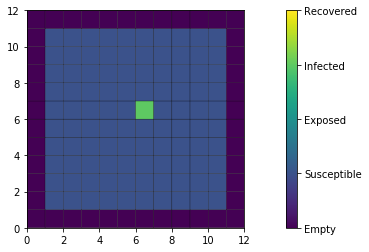

In [6]:
def plot_initial (G, vmin=EMPTY, vmax=RECOVERED, values="states"):
    """A helper routine to visualize a 2-D world."""
    # Set color range
    assert values in ["states", "bool"]
    if values == "states":
        vticks = range (vmin, vmax+1)
        vlabels = ['Empty', 'Susceptible','Exposed','Infected','Recovered']
    else:
        vticks = [0, 1]
        vlabels = ['False (0)', 'True (1)']
    
    m, n = G.shape[0]-2, G.shape[1]-2
    plt.pcolor (G, vmin=vmin, vmax=vmax, edgecolor='black')
    cb = plt.colorbar ()
    cb.set_ticks (vticks)
    cb.set_ticklabels (vlabels)
    plt.axis ('square')
    plt.axis ([0, m+2, 0, n+2])
    return

# Create an empty world at time t=0
N = 10
initial_test = create_world (N)
plot_initial (initial_test)

In [7]:

# assert initial_test.shape == (N+2, N+2)
# assert np.sum (initial_test) == ((4*N+4)*EMPTY + INFECTED)
# assert len (np.where (initial_test == INFECTED)[0]) == 1

# i_mid = int ((N+2) / 2)
# assert initial_test[i_mid, i_mid] == INFECTED

# print ("\n(Passed.)")

In [8]:
## detect functions
def susceptible (G):
    return (G == SUSCEPTIBLE).astype (int)


def infected (G):
    return (G==INFECTED).astype (int)

def exposed (G):
    return (G==EXPOSED).astype (int)

def exposing_index (G):
    """
    Returns a grid whose (i, j) entry is 1 if it has
    at least 1 infected neighbor, or 0 otherwise.
    """
    E = np.zeros (G.shape, dtype=int) # exposed people
    ### BEGIN SOLUTION
    I = infected (G)+exposed(G)
    E[1:-1, 1:-1] = I[0:-2, 1:-1] | I[1:-1, 2:] | I[2:, 1:-1] | I[1:-1, 0:-2]
    ### END SOLUTION
    return E

# Visualizes your results:

def recovered (G):
    return (G==RECOVERED).astype (int)

def days_count_initial(G):
    ###
    D = np.zeros(G.shape,dtype = int)
    return D

print ("There are", count (susceptible (initial_test)), "susceptible patient(s) initially")
print ("There are", count (infected (initial_test)), "infected patient(s) initially")
print ("There are", count (exposed (initial_test)), "marked exposed patient(s) in latent phase initially")
print ("There are", count (recovered (initial_test)), "recovered patient(s) initially")
print ("There are", count (exposing_index (initial_test)), "found exposing patient(s).")
D = days_count_initial(initial_test)

('There are', 99, 'susceptible patient(s) initially')
('There are', 1, 'infected patient(s) initially')
('There are', 0, 'marked exposed patient(s) in latent phase initially')
('There are', 0, 'recovered patient(s) initially')
('There are', 4, 'found exposing patient(s).')


In [9]:
PROB_Exposure = 0.10 #conditional probability of getting sick, given any sick neighbors
PROB_Exposure2Recovered = 0.8
PROB_Exposure2Infectious = 1- PROB_Exposure2Recovered
PROB_Recover = 0.96
E_time_thresh = 14 # days
I_time_thresh = 21 # days
np.random.seed (1602034230) # 
### define a asymptoms matrix to identify whom will show no symptoms if exposed
def asymptoms_matrix(G,recover = PROB_Exposure2Recovered):
    random = np.random.uniform(size=G.shape)
    G_a = (random<recover)
    return G_a.astype(int)

G_asymptoms_index = asymptoms_matrix(initial_test)
print(G_asymptoms_index)
def expired_day(G_asymptoms,E_time_thresh, I_time_thresh):
    #day count probability between 0-1
    random = np.random.uniform(size=G_asymptoms.shape)
    # return the day counts distribution for E could be I and E could be R 
    G_symptoms = np.round((G_asymptoms<1)*random*E_time_thresh)
    G_asymptoms = np.round(G_asymptoms*(random*(I_time_thresh)+E_time_thresh))
    G_days = G_symptoms+G_asymptoms
    return G_days
G_days_change = expired_day(G_asymptoms_index, E_time_thresh,I_time_thresh)
# print(G_days_change)
# print(G_days_change==G_days_change)


[[1 1 0 1 1 1 1 1 1 1 0 1]
 [1 1 0 0 1 1 0 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1 0 1]
 [1 1 0 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 0 0 1 1 0 1 0 1]
 [1 0 1 1 1 1 0 1 1 0 1 1]
 [0 1 0 1 1 1 1 1 1 1 1 1]]


In [10]:

def spreads (G,G_asymptoms_index,G_days_change,D,tau=PROB_Exposure,theta=PROB_Recover, E_time = E_time_thresh, I_time=I_time_thresh):
    #### update counter, new iteration update now, all start at 0 at iteration = 0. existing E and I +=1.
#     print(G)
    D_update = D+infected(G)+exposed(G)
    
    
    ###find the getting exposed surroundings of infected, including being exposed by I. 
    random_draw_s2e = np.random.uniform (size=G.shape)
    random_draw_i2r = np.random.uniform (size=G.shape)
    
    G_e = (susceptible (G) * exposing_index (G) * (random_draw_s2e > tau))
    # for the pecent that turned to I from E
    G_i = exposed(G)*(G_asymptoms_index<1)*(G_days_change==D_update)
    G_r_from_e = exposed(G)*G_asymptoms_index*(G_days_change==D_update)
    G_r_from_i = infected(G)*(random_draw_i2r > theta)
    D_final =D_update - D_update*G_e
    
    G = G-G*(G_e+G_i+G_r_from_e+G_r_from_i)+G_e*EXPOSED+G_i*INFECTED+(G_r_from_e+G_r_from_i)*RECOVERED

#     print(G)
#     print(D_final)
    return G, D_final






/home/muyangguo/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


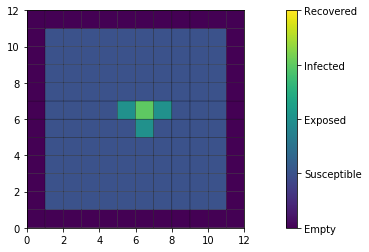

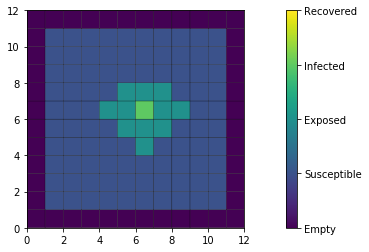

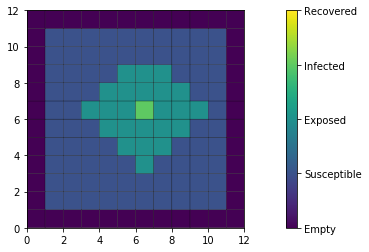

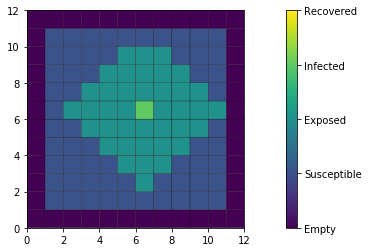

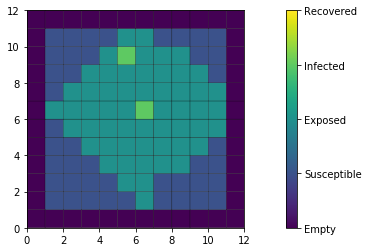

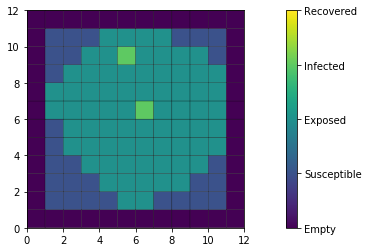

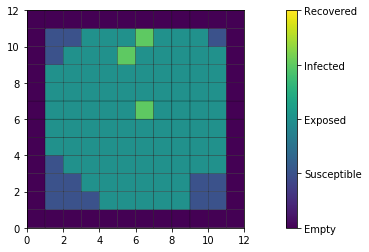

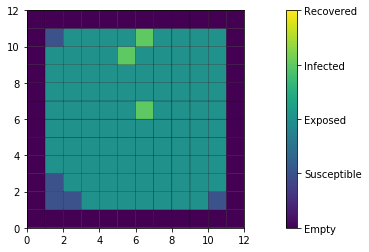

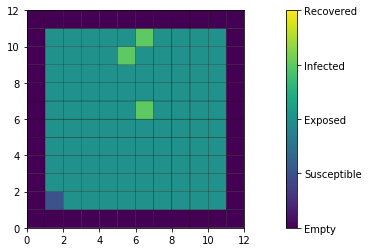

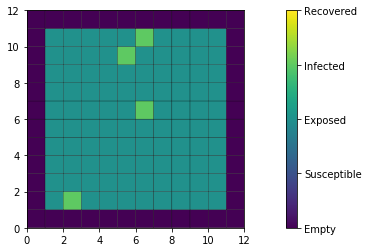

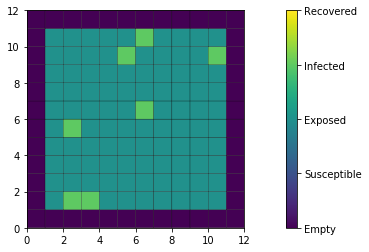

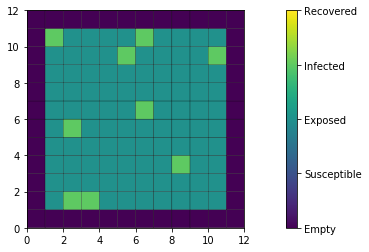

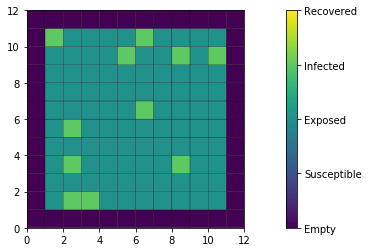

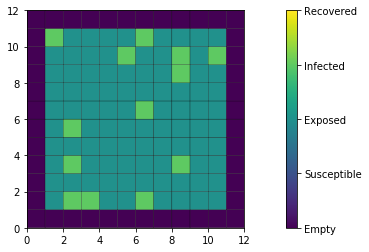

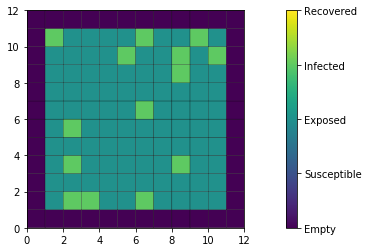

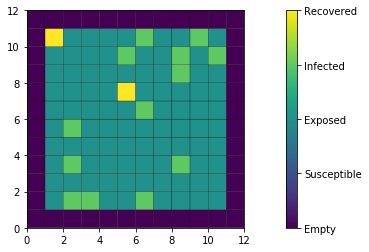

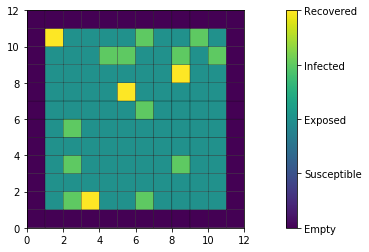

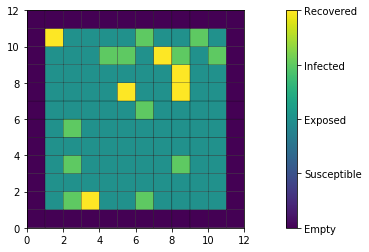

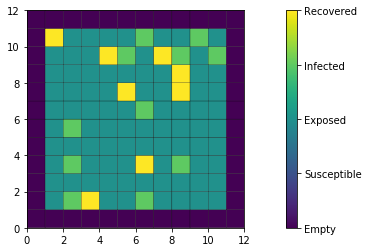

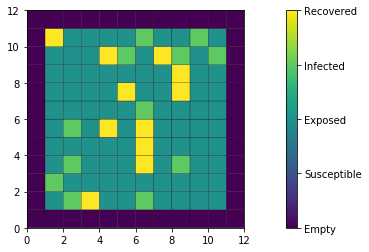

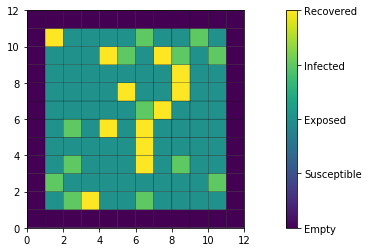

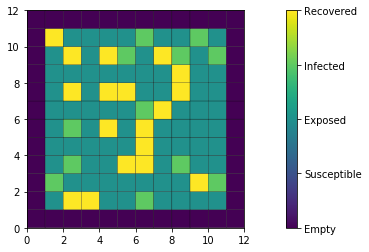

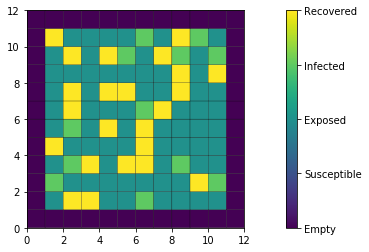

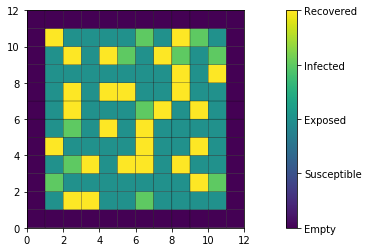

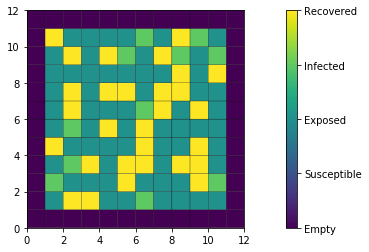

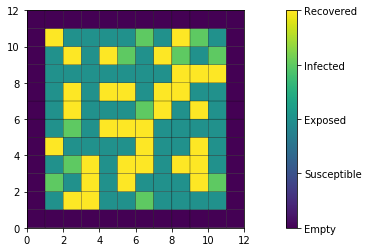

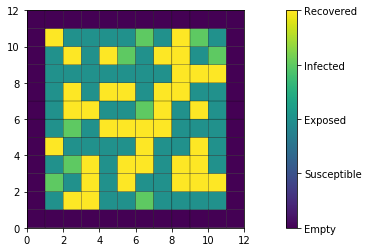

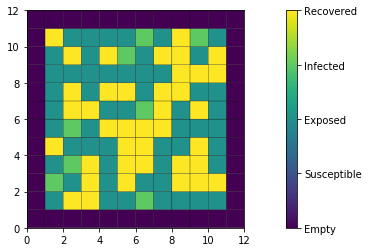

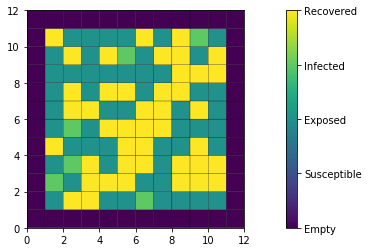

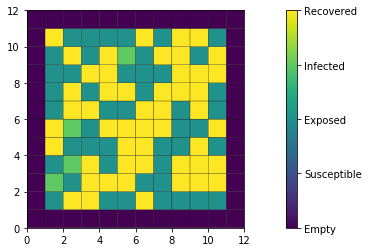

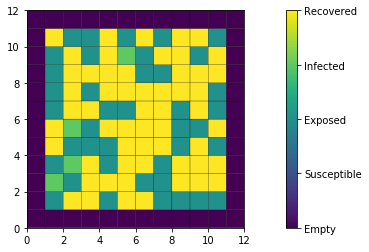

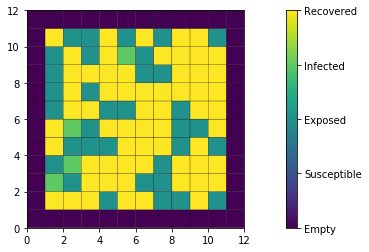

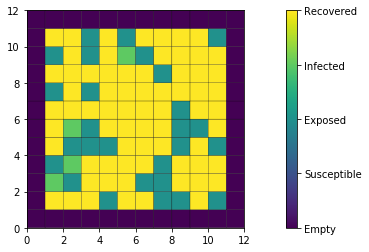

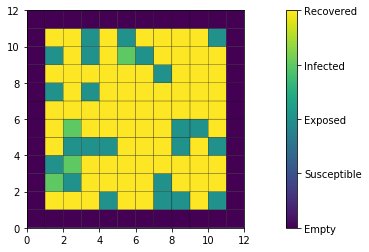

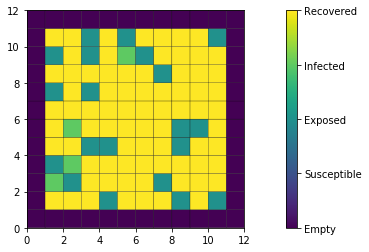

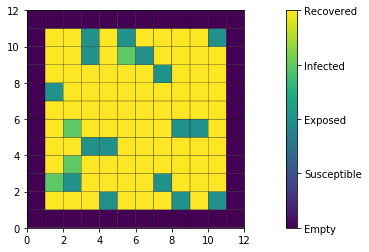

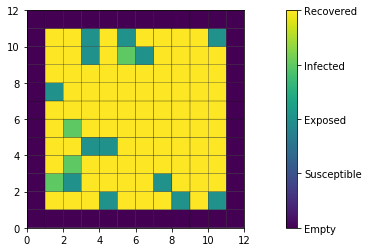

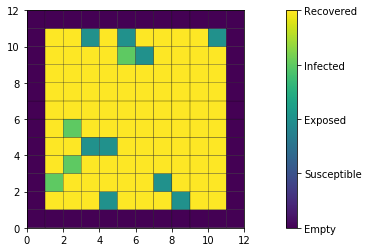

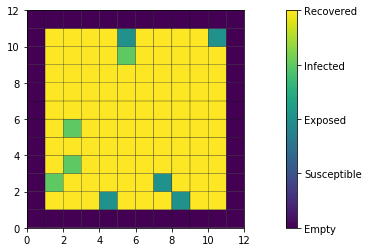

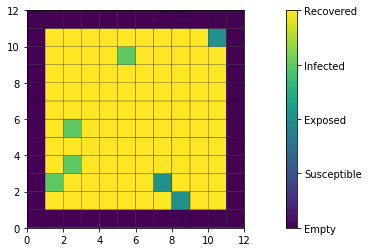

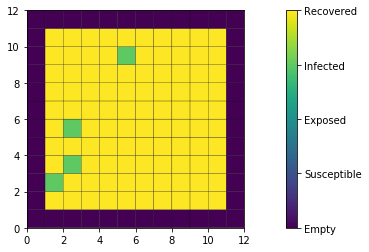

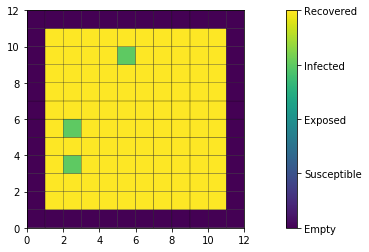

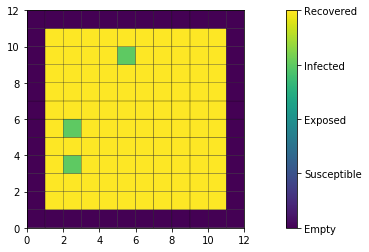

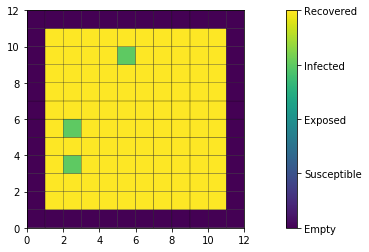

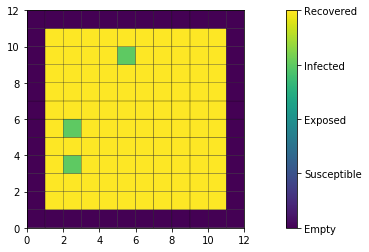

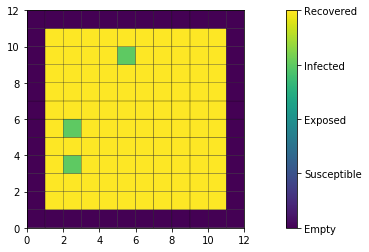

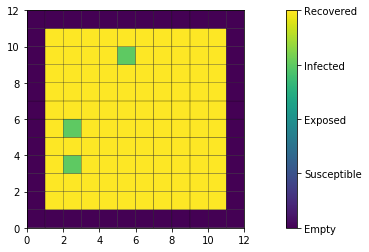

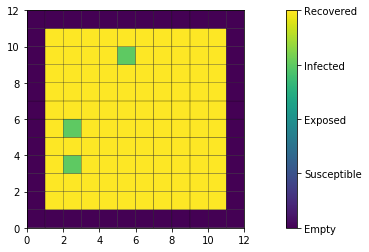

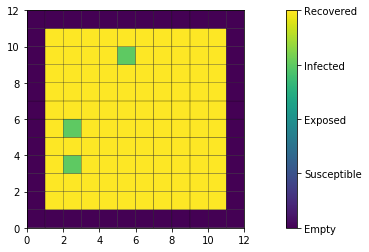

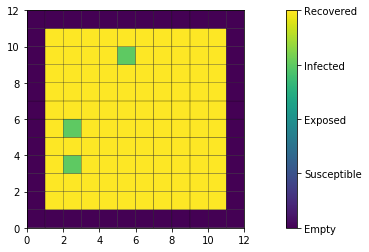

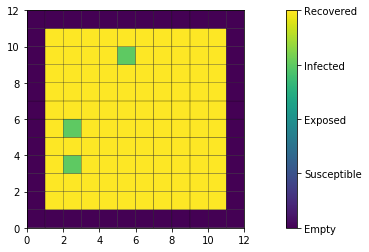

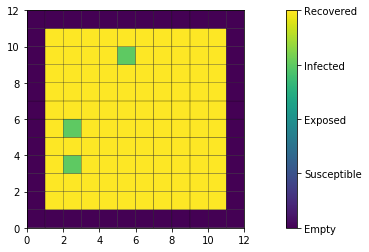

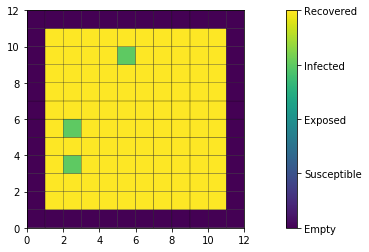

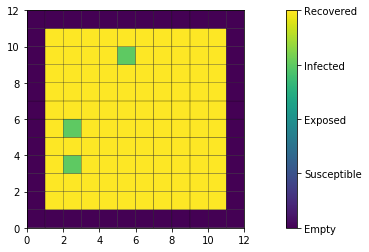

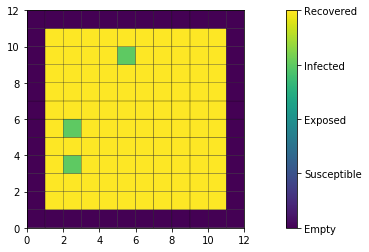

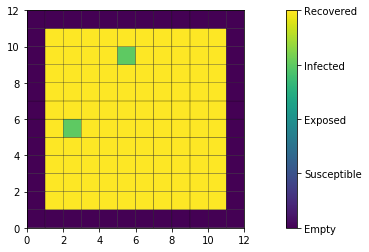

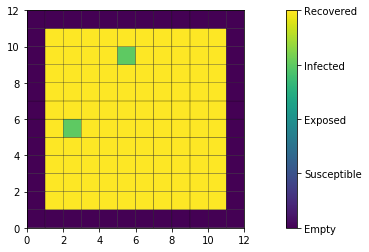

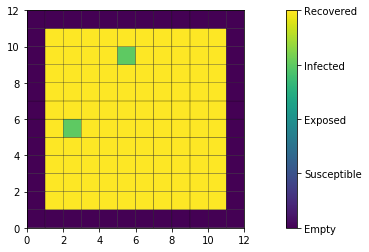

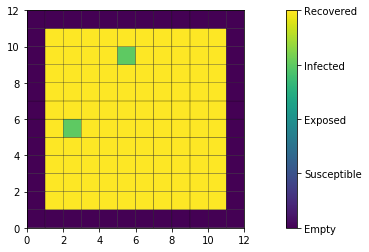

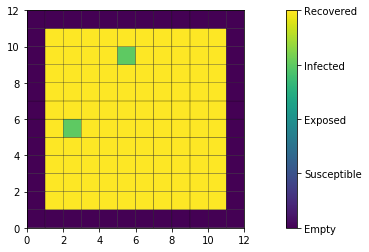

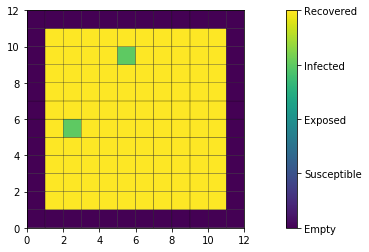

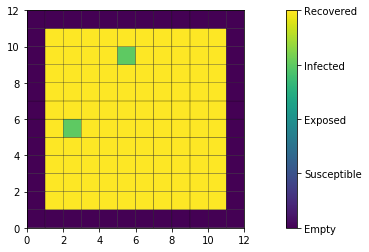

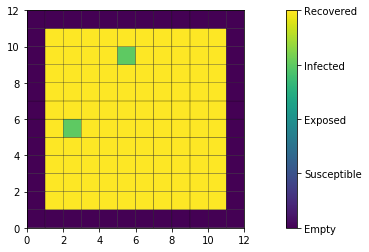

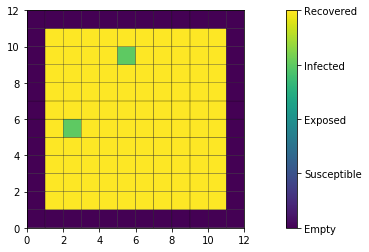

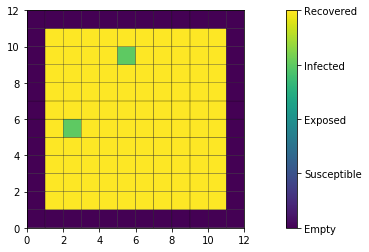

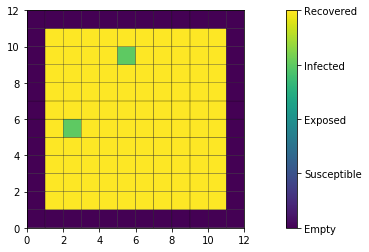

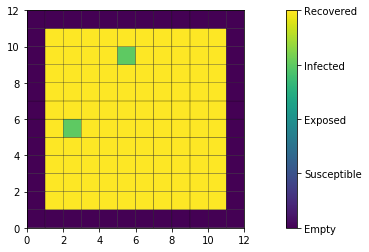

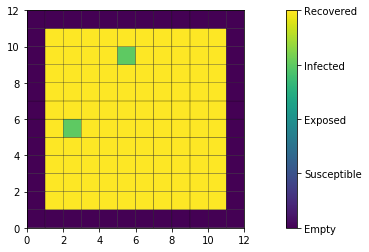

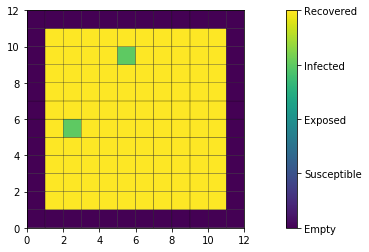

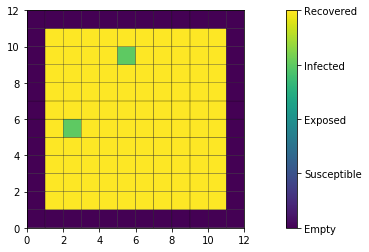

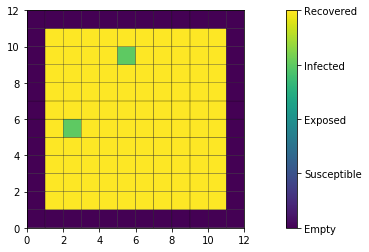

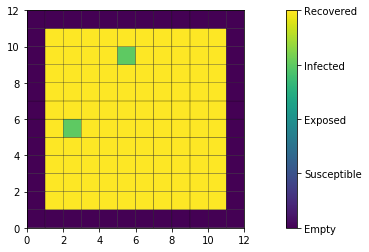

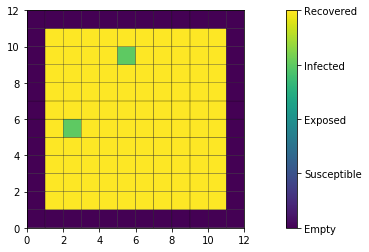

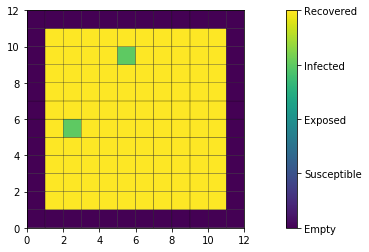

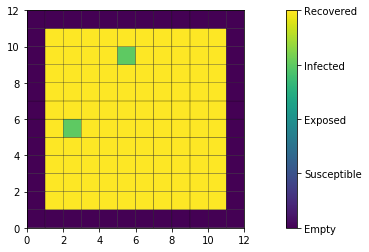

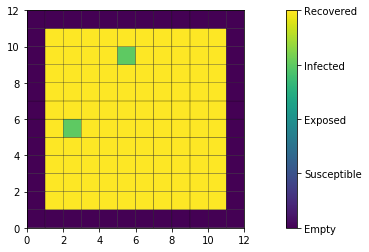

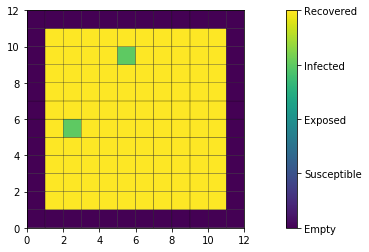

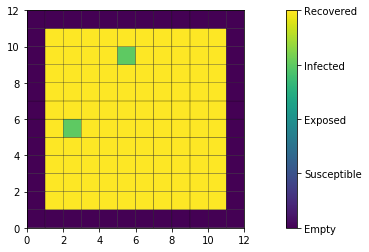

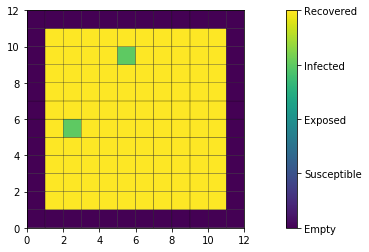

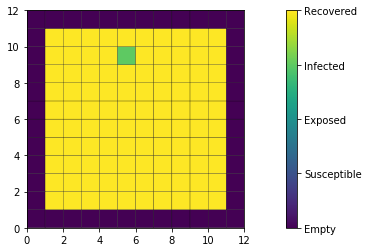

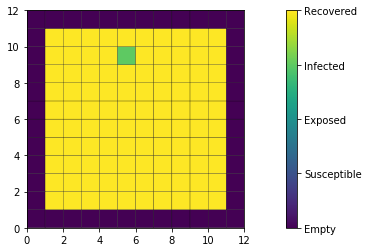

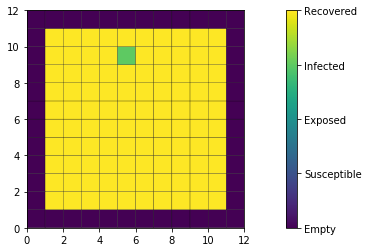

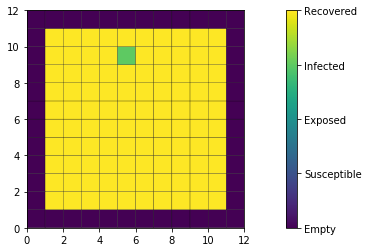

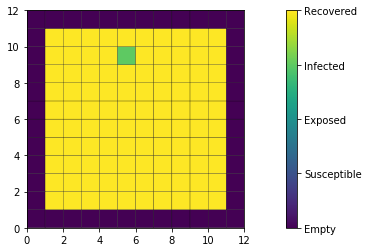

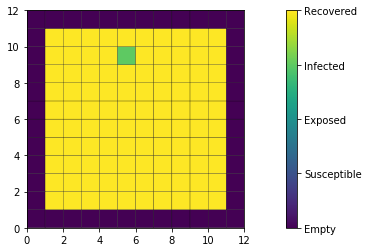

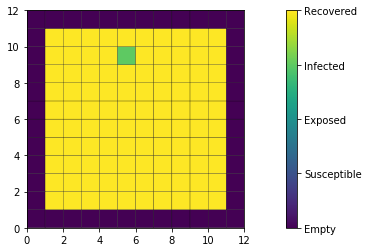

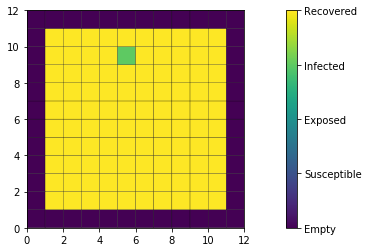

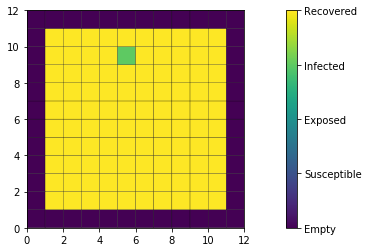

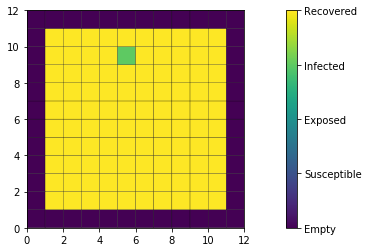

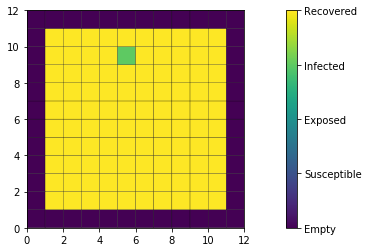

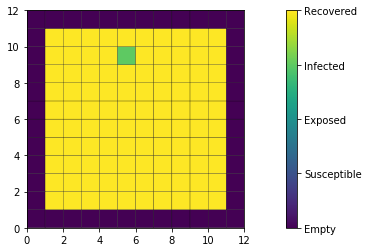

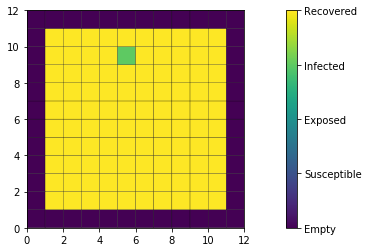

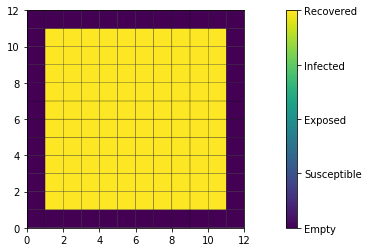

In [11]:
def simulate_ca_modified_seir(max_iteration,initial_test,D):
    container = {"S":[],"E":[],"I":[],"R":[]}
    container["S"].append(np.sum(susceptible(initial_test)))
    container["E"].append(np.sum(exposed(initial_test)))
    container["I"].append(np.sum(infected(initial_test)))
    container["R"].append(np.sum(recovered(initial_test)))

    population = np.sum(container.values())
    for i in range(max_iteration):
        initial_test, D = spreads(initial_test, G_asymptoms_index,G_days_change,D)
        container["S"].append(np.sum(susceptible(initial_test)))
        container["E"].append(np.sum(exposed(initial_test)))
        container["I"].append(np.sum(infected(initial_test)))
        recovered_total = np.sum(recovered(initial_test))
        container["R"].append(recovered_total)
        fig = plt.figure ()
        plot_initial(initial_test)
        plt.savefig('./ca_outputs/test_'+str(i)+'.png',dpi=600)
        if recovered_total == population:
            return initial_test, D,container
    return initial_test, D,container


result_test, counter,container = simulate_ca_modified_seir(200,initial_test,D)





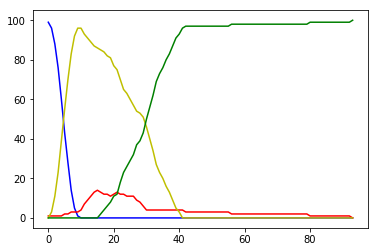

In [12]:
S = container["S"]
I = container["I"]
E = container["E"]
R = container["R"]

fig, ax = plt.subplots()
ax.plot(range(len(S)),S,'b')
ax.plot(range(len(S)),I,'r')
ax.plot(range(len(S)),E,'y')
ax.plot(range(len(S)),R,'g')

# for i in range(len(state_list)):
#     ax[i].plot(date,container[state_list[i]][0],'o-',label="confirmed", linewidth=0.5,markersize=1)
#     ax[i].plot(date,container[state_list[i]][1],'rd-',label= "deaths", linewidth=0.5,markersize=1)
#     ax[i].set_title(state_list[i],fontsize = 10)
#     ax[i].tick_params(axis='x',labelsize=4)
#     ax[i].tick_params(axis='y',labelsize=8)
#     ax[i].legend(fontsize = 8)
#     ax[i].set_xticks(date[::7])
#     ax[i].set_xticklabels(date[::7], rotation=30)

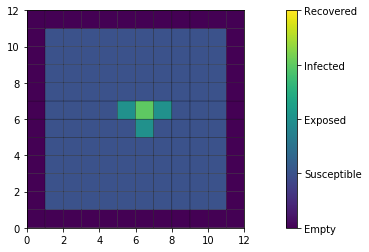

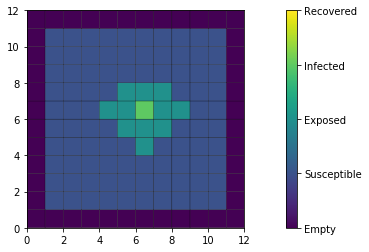

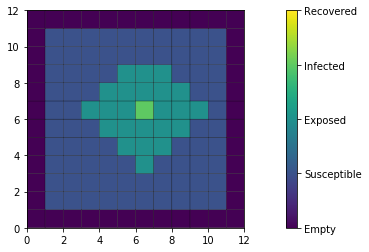

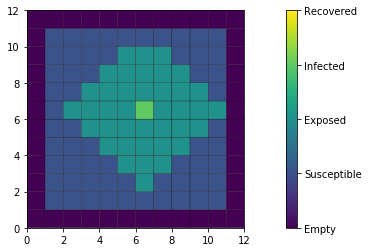

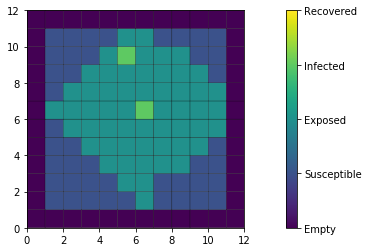

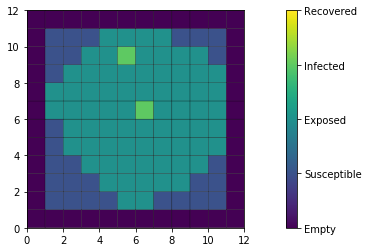

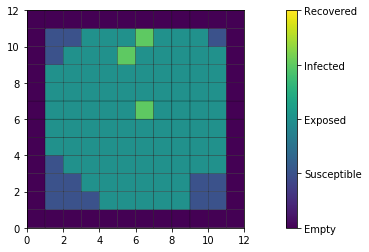

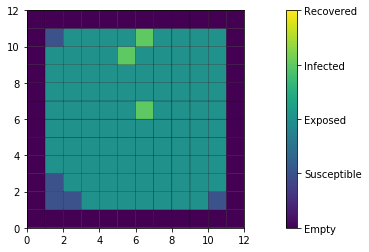

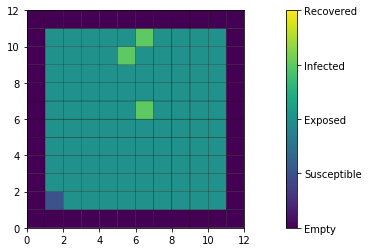

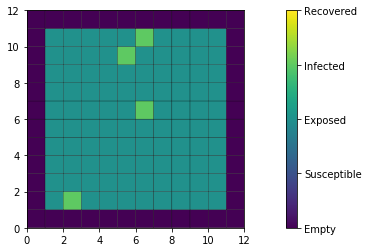

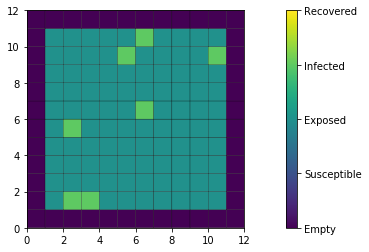

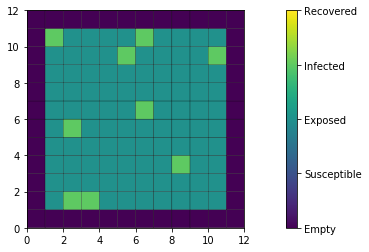

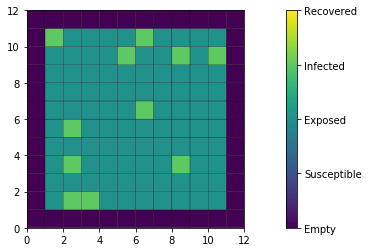

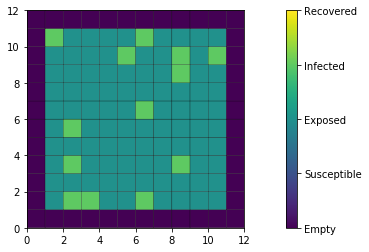

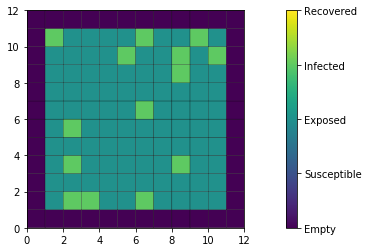

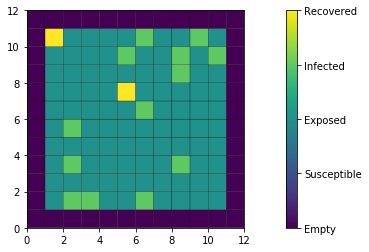

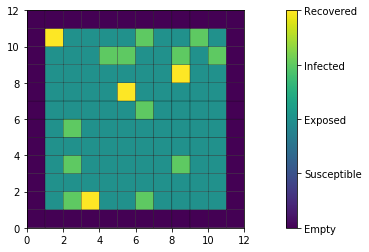

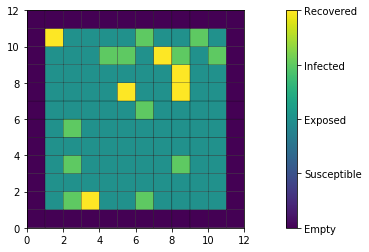

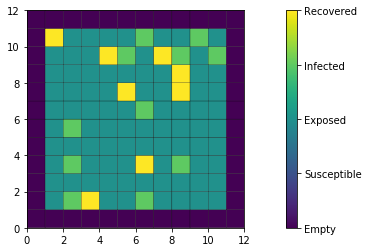

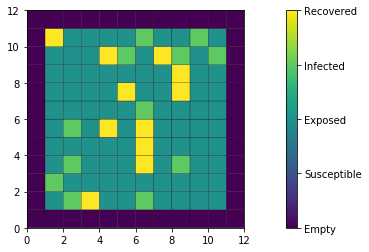

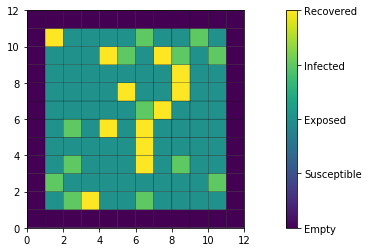

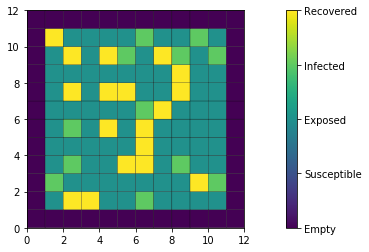

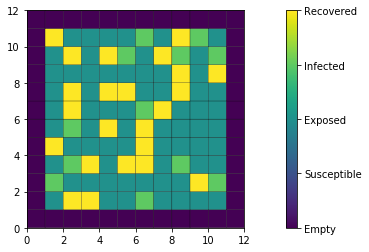

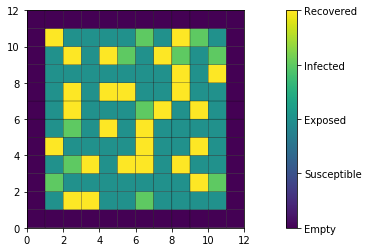

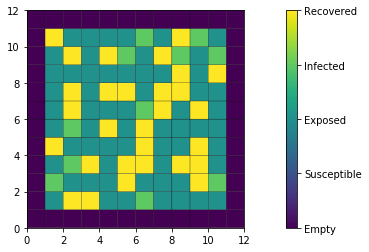

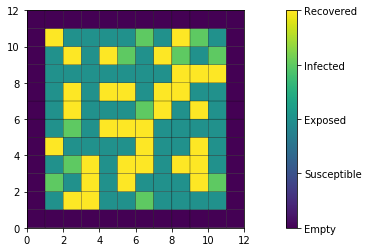

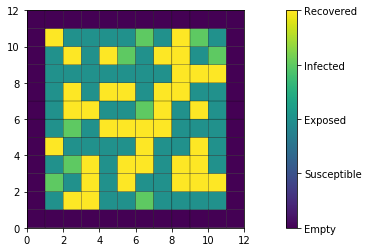

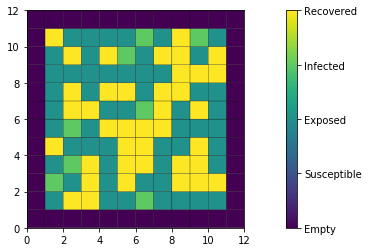

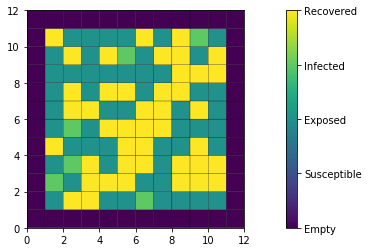

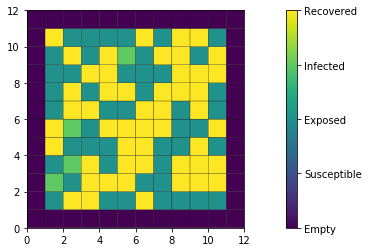

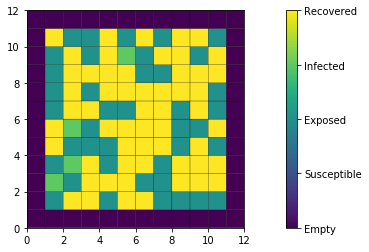

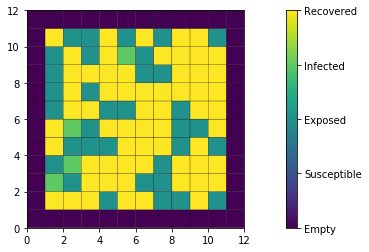

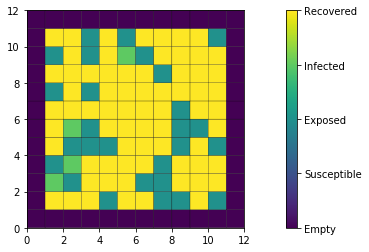

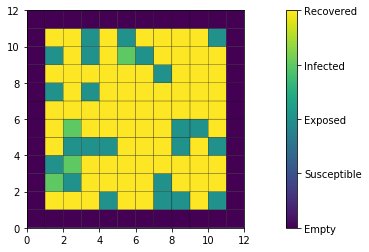

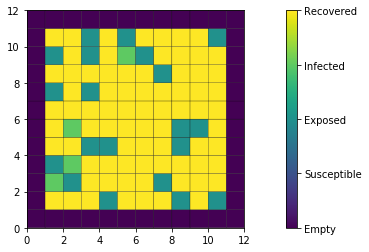

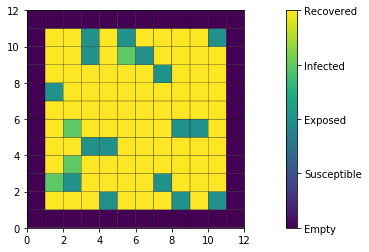

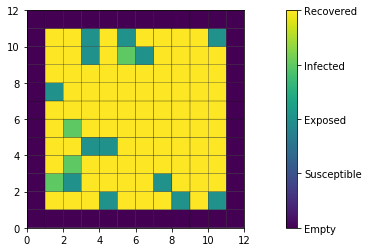

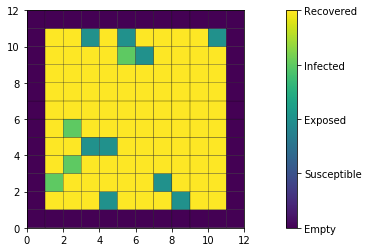

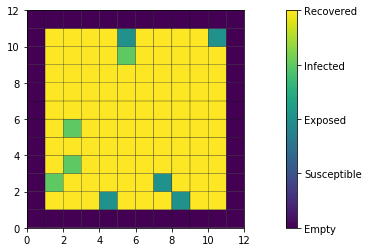

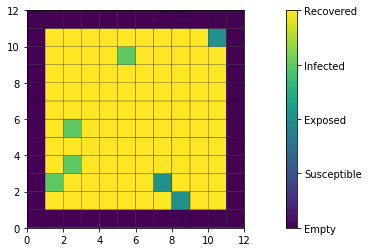

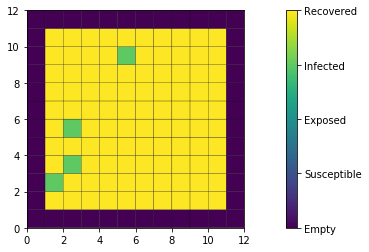

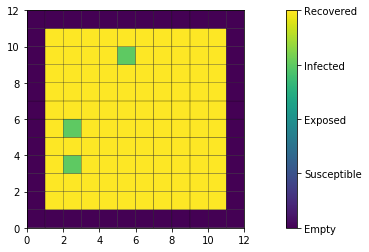

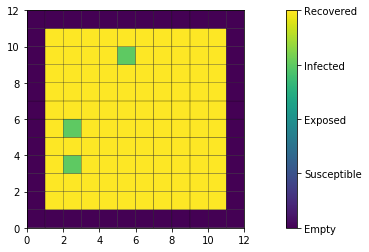

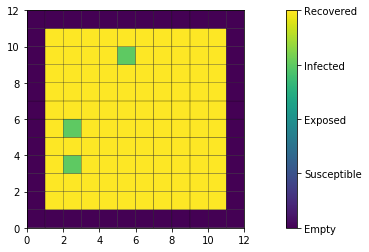

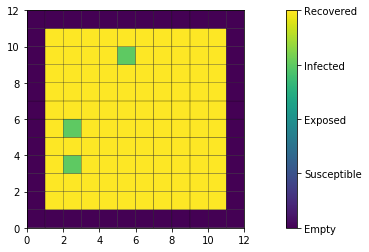

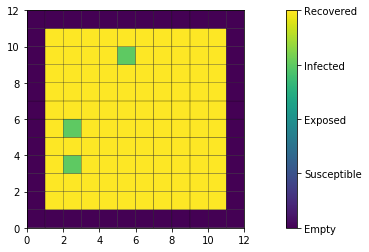

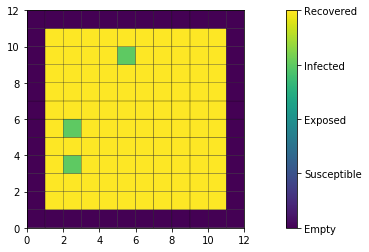

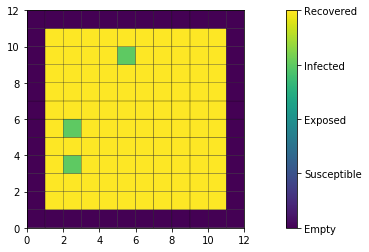

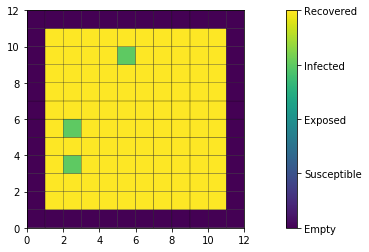

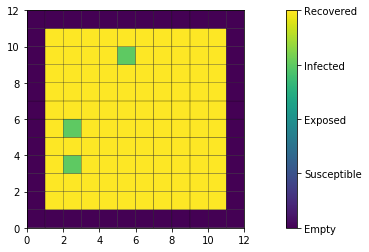

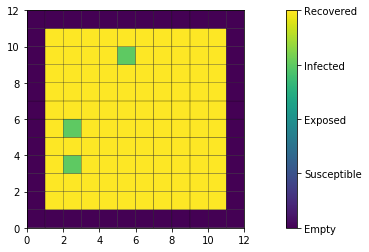

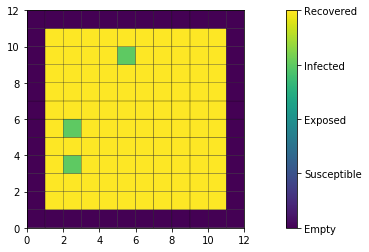

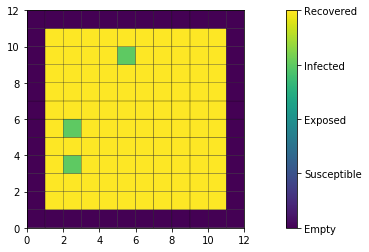

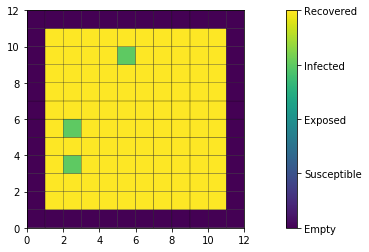

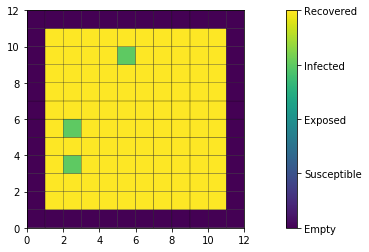

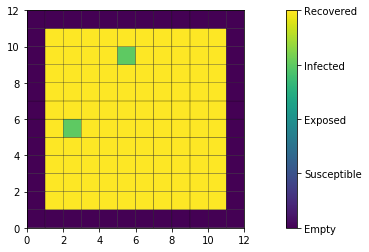

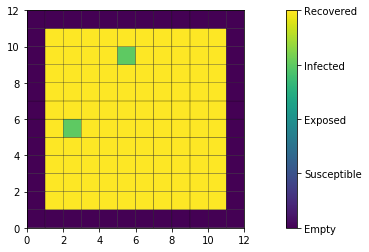

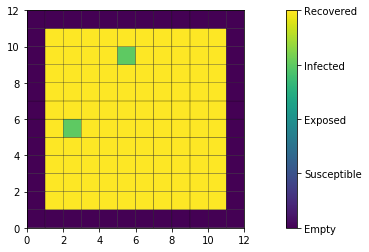

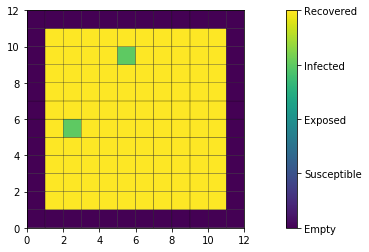

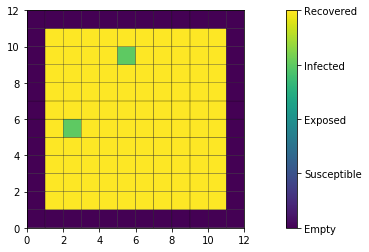

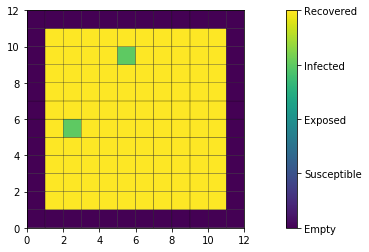

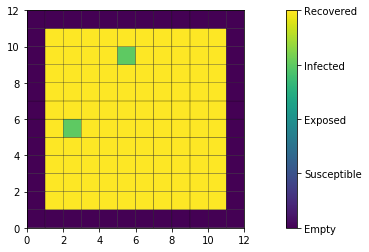

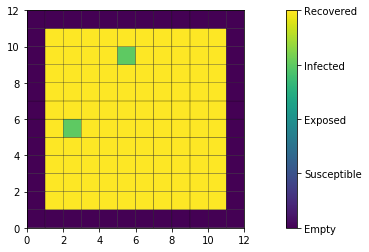

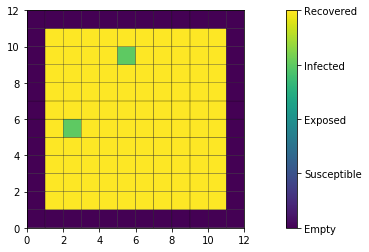

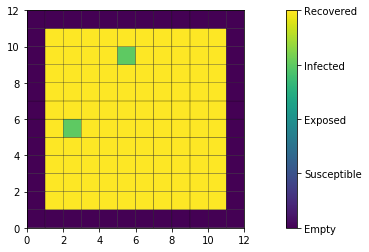

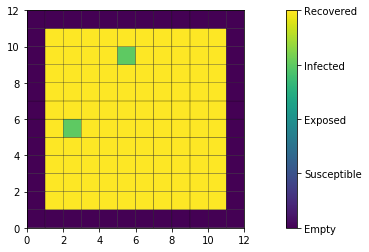

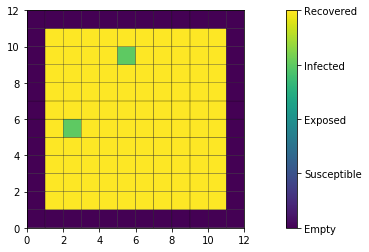

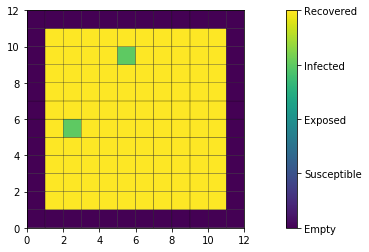

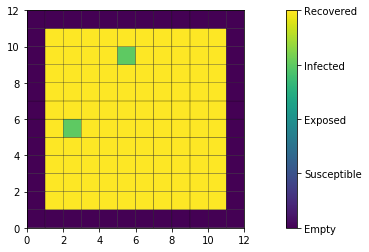

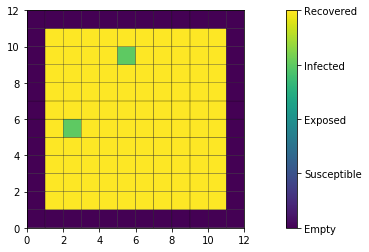

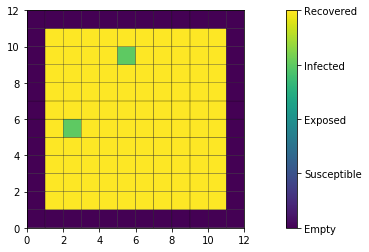

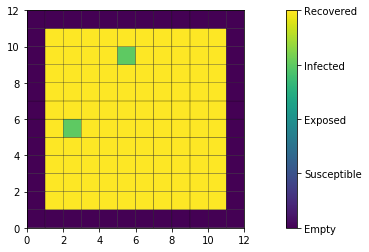

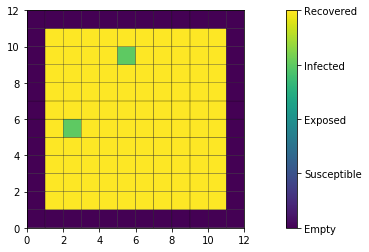

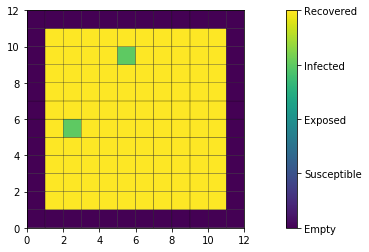

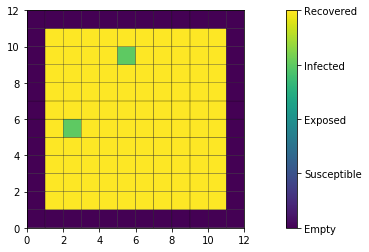

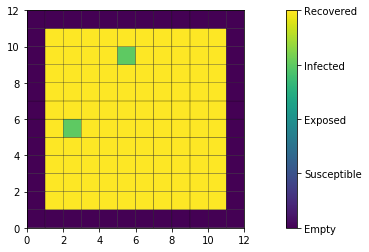

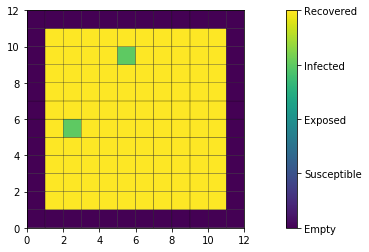

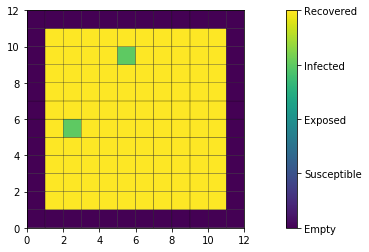

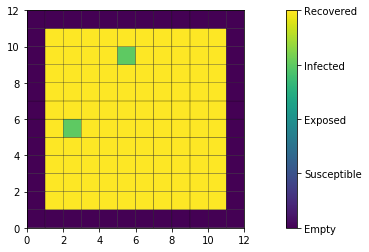

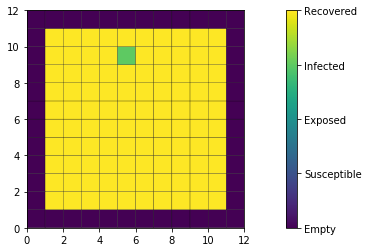

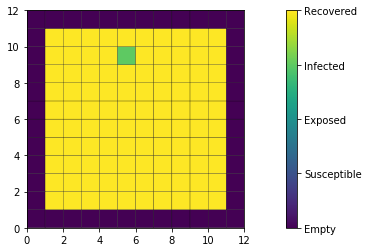

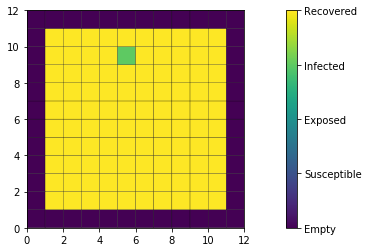

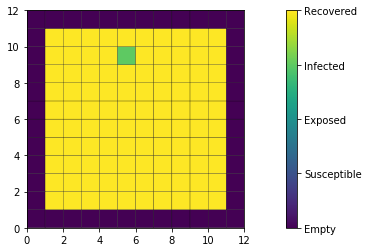

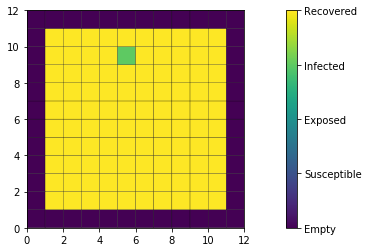

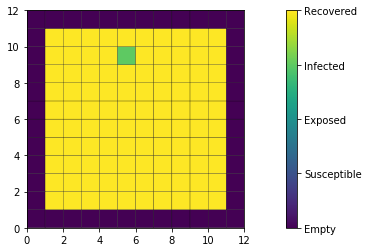

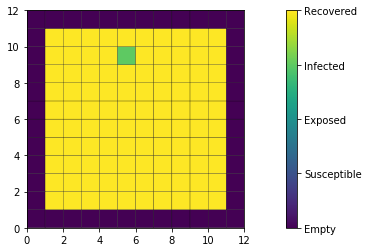

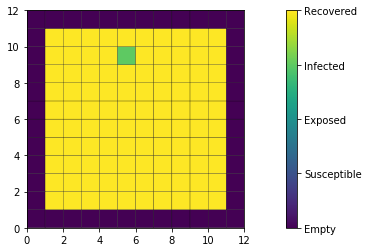

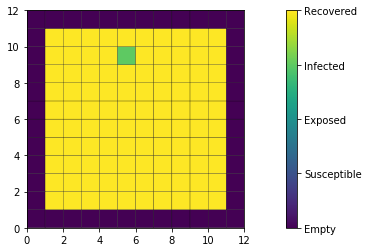

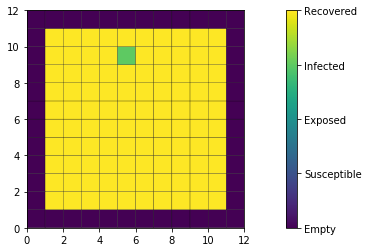

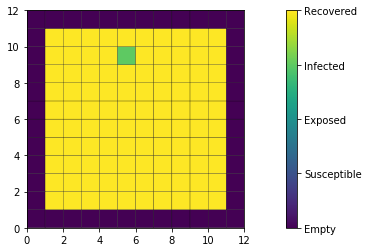

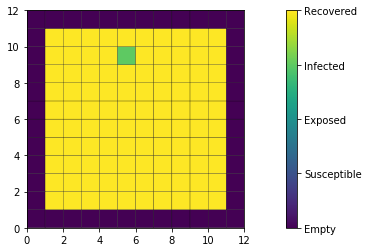

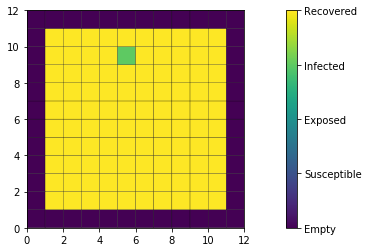

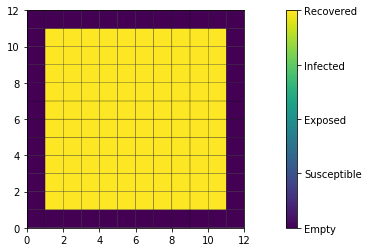

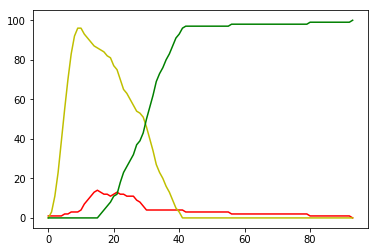

In [13]:
# Create an empty world at time t=0
EMPTY = -1
SUSCEPTIBLE = 0
EXPOSED = 1
INFECTED = 2
RECOVERED = 3
PROB_Exposure = 0.10 #conditional probability of getting sick, given any sick neighbors
PROB_Exposure2Recovered = 0.8
PROB_Exposure2Infectious = 1- PROB_Exposure2Recovered
PROB_Recover = 0.96
E_time_thresh = 14 # days
I_time_thresh = 21 # days
np.random.seed (1602034230) # 
N = 10
scale_test = create_world (N)
# plot_initial (scale_test)
D_counter = days_count_initial(scale_test)
G_asymptoms_index = asymptoms_matrix(scale_test)
G_days_change = expired_day(G_asymptoms_index, E_time_thresh,I_time_thresh)
result_test, counter,container = simulate_ca_modified_seir(100,scale_test,D_counter)
S = container["S"]
I = container["I"]
E = container["E"]
R = container["R"]


fig, ax = plt.subplots()
# ax.plot(range(len(S)),S,'b')
ax.plot(range(len(S)),I,'r')
ax.plot(range(len(S)),E,'y')
ax.plot(range(len(S)),R,'g')


In [14]:
from IPython.display import HTML
HTML('<img src="ca-modified-SEIR-10000.gif">')

